# Модерация токсичных комментариев для интернет-магазина «Викишоп»

**Описание проекта**: Интернет-магазин «Викишоп» запускает новый сервис, в котором пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель исследования**: Построить модель машинного обучения для классификации комментариев на позитивные и негативные. 

**Ход исследования:**

- *Шаг 1.* Подготовка и предобработка данных.
- *Шаг 2.* Обучение и анализ модели.
- *Шаг 3.* Выводы.

**Общий вывод**: По итогам проведенного анализа и разработки модели машинного обучения появится возможность искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**
Набор данных с разметкой о токсичности правок имеет следующие признаки:
- `text` — текст комментария.
- `toxic` — целевой признак.


## Подготовка и предобработка данных

### Импортирование библиотек

In [1]:
# Установим библиотеки, которые понадобятся для работы над проектом. 
!pip install -q lightgbm
!pip install -q wordcloud
!pip install -q Pillow

# Обновляем библиотеки, так как выдавал ошибки
!pip install -Uq scikit-learn
!pip install -Uq Pillow

In [2]:
# Импортируем библиотеки, которые понадобятся для работы над проектом. 
import time
import warnings
from tqdm.notebook import tqdm

# для датафрейма 
import pandas as pd
import numpy as np

# для предпроцессинга и лемматизации текстов
import nltk
import string
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
stopwords.words("english")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# для визуализации 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
from PIL import Image
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# для машинного обучения
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

# модели 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# метрики
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Зафисируем константы

RANDOM_STATE = 42
STOP_WORDS = stopwords.words('english')

### Загрузка данных 

In [4]:
# Считаем данные из csv-файла в датафрейм и сохраним в переменную. 

try:
    df_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    df_comments = pd.read_csv('https://code.s3.yandex.net//datasets/toxic_comments.csv', index_col=[0])

In [5]:
# Функция вывода основной информации о файлах-датафреймах

def main_info(df):
    # Информация о структуре датафрейма
    print("Информация о структурах:")
    df.info()
    print("\n")
    display(df.shape)
    print('-----')
    
    # Статистическое описание колонок
    print("Статистика:")
    display(df.describe().T)
    print("\n")
    print('-----')
    
    # Первые десять строк датафрейма
    print("Первые строки:")
    display(df.head(10))
    print("\n")
    print('-----')
    
    # Информация о дубликатах
    print("Количество явных дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print("\n")
    print('-----')
    
    # Информация о пропусках
    print("Количество пропусков в датафрейме:")
    display(df.isna().sum())
    print("\n")
    print('-----')

In [6]:
# Выведем основную информацию о датафрейме df_comments

main_info(df_comments)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB




(159292, 2)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0




-----
Первые строки:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0




-----
Количество явных дубликатов в датафрейме:


0



-----
Количество пропусков в датафрейме:


text     0
toxic    0
dtype: int64



-----


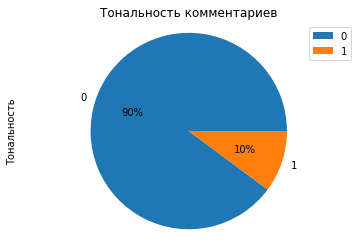

In [7]:
# Визуализируем распределение целевого признака

counts = df_comments['toxic'].value_counts() # подсчет количества записей каждой категории токсичности

# Создание круговой диаграммы
ax = counts.plot(
    kind='pie',
    y='count',
    autopct='%1.0f%%',      # Формат отображения процентов
    title='Тональность комментариев',  
    legend=True,           
    ylabel='Тональность'    
)
plt.axis('equal')         
plt.show()                  

**Комментарии**

Датасет из файла `toxic_comments.csv` мы сохранили в переменную `df_comments`. Он содержит 159292   строк и 2 столбца. Пропусков в данных нет. Названия столбцов соответствуют правилам snake_case. На первый взгляд данные выглядят нормально, но текст требует предобработки. Целевой признак распределен 1:9.

### Предобработка данных и исследовательский анализ

In [8]:
# Функция для POS-теггинга

def pos_to_wordnet(pos):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(pos.upper(), wordnet.NOUN)

In [9]:
# Функция для предобработки и лемматизации текста

def preprocess_lemmatize(text):

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    lower_text = text.lower() # приводим все слова к нижнему регистру
    clear_text = re.sub(r'[^a-zA-Z\']', ' ', lower_text)  # очищаем текст от символов кроме букв и апострофов
    text_without_punct = clear_text.translate(str.maketrans('', '', string.punctuation)) # удаляем пунктуацию из текста
    text_tokens = word_tokenize(text_without_punct, language="english") # токенизируем текст превращая его в список
    filtered_tokens = [word for word in text_tokens if word not in stop_words] # убираем стоп слова
    
    # Определяем часть речи и лемматизируем каждое слово с учетом части речи
    lemmatized_tokens = []
    for token in filtered_tokens:
        pos = nltk.pos_tag([token])[0][1][0]  # Получаем первую букву POS-тега
        lemma = lemmatizer.lemmatize(token, pos=pos_to_wordnet(pos))
        lemmatized_tokens.append(lemma)
    
    # Возвращаем обработанный текст обратно в строку
    return ' '.join(lemmatized_tokens)

In [10]:
# Проверим работу функции предобработки и лемматизации текста

sentence = "The striped bats are hanging on their feet for best"

print(preprocess_lemmatize(sentence))

strip bat hang foot best


In [11]:
# Сохраняем отдельно предобработанные токсичные комментарии для визуализации
tqdm.pandas()

word_could_dict_toxic = df_comments.loc[df_comments['toxic'] == 1, 'text'].progress_apply(preprocess_lemmatize)
display(word_could_dict_toxic)

  0%|          | 0/16186 [00:00<?, ?it/s]

6                               cocksucker piss around work
12        hey talk exclusive group wp taliban good destr...
16             bye dont look come think comming back tosser
42        gay antisemmitian archangel white tiger meow g...
43                                fuck filthy mother as dry
                                ...                        
159374    previous conversation fuck shit eat liberal ma...
159394                              mischievious pubic hair
159421    absurd edits absurd edits great white shark to...
159426    hey listen dont ever delete edits ever im anno...
159434    im go keep post stuff u delete fuck site close...
Name: text, Length: 16186, dtype: object

In [12]:
# Сохраняем отдельно предобработанные нетоксичные комментарии для визуализации
tqdm.pandas()

word_could_dict_positive = df_comments.loc[df_comments['toxic'] == 0, 'text'].progress_apply(preprocess_lemmatize)
display(word_could_dict_toxic)

  0%|          | 0/143106 [00:00<?, ?it/s]

6                               cocksucker piss around work
12        hey talk exclusive group wp taliban good destr...
16             bye dont look come think comming back tosser
42        gay antisemmitian archangel white tiger meow g...
43                                fuck filthy mother as dry
                                ...                        
159374    previous conversation fuck shit eat liberal ma...
159394                              mischievious pubic hair
159421    absurd edits absurd edits great white shark to...
159426    hey listen dont ever delete edits ever im anno...
159434    im go keep post stuff u delete fuck site close...
Name: text, Length: 16186, dtype: object

In [13]:
# Функция для создания списка слов

def get_word_list (texts):
    data = []
    
    for text in texts:
        data.extend(text.split())
    return data

In [14]:
# Создаем списки слов токсичных и нетоксичных комментариев

positive_list = Counter(get_word_list(word_could_dict_positive)).most_common()
toxic_list = Counter(get_word_list(word_could_dict_toxic)).most_common()

# Теперь выводим топ-5
print('Топ-10 частотных слов токсичных комментариев:')
for word, freq in toxic_list[:10]:
    print(f'{word}: {freq}')
    
print('\nТоп-10 частотных слов нетоксичных комментариев:')
for word, freq in positive_list[:10]:
    print(f'{word}: {freq}')

Топ-10 частотных слов токсичных комментариев:
fuck: 13524
suck: 4820
go: 4321
like: 3948
wikipedia: 3838
dont: 3835
shit: 3722
u: 3487
nigger: 3434
get: 3379

Топ-10 частотных слов нетоксичных комментариев:
article: 72272
page: 54253
wikipedia: 42004
talk: 38526
use: 30911
edit: 29064
one: 28881
please: 28734
make: 28215
would: 28040


In [15]:
def wordcloud(freq_dict):
    wordcloud = WordCloud(width = 1000, height = 500, background_color="white", colormap='rainbow')
    wordcloud.generate_from_frequencies(frequencies=freq_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [16]:
# Визуализируем облако слов для токсичных комментариев
wordcloud_toxic = wordcloud(word_could_dict_toxic)

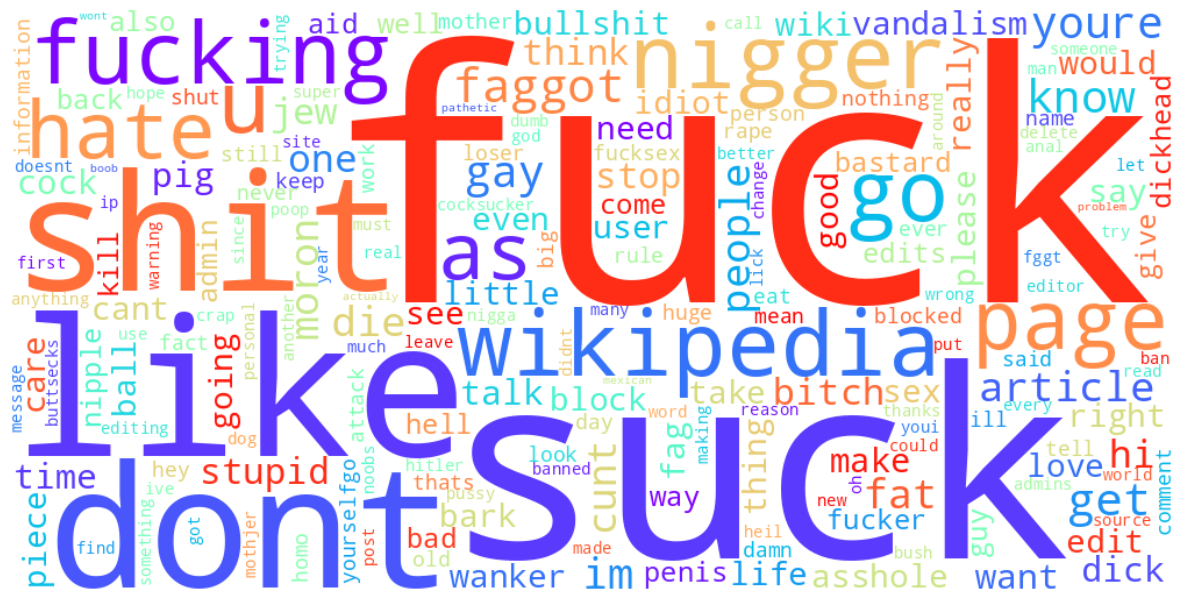

In [17]:
# Визуализируем облако слов для нетоксичных комментариев

wordcloud_positive = wordcloud(word_could_dict_positive)

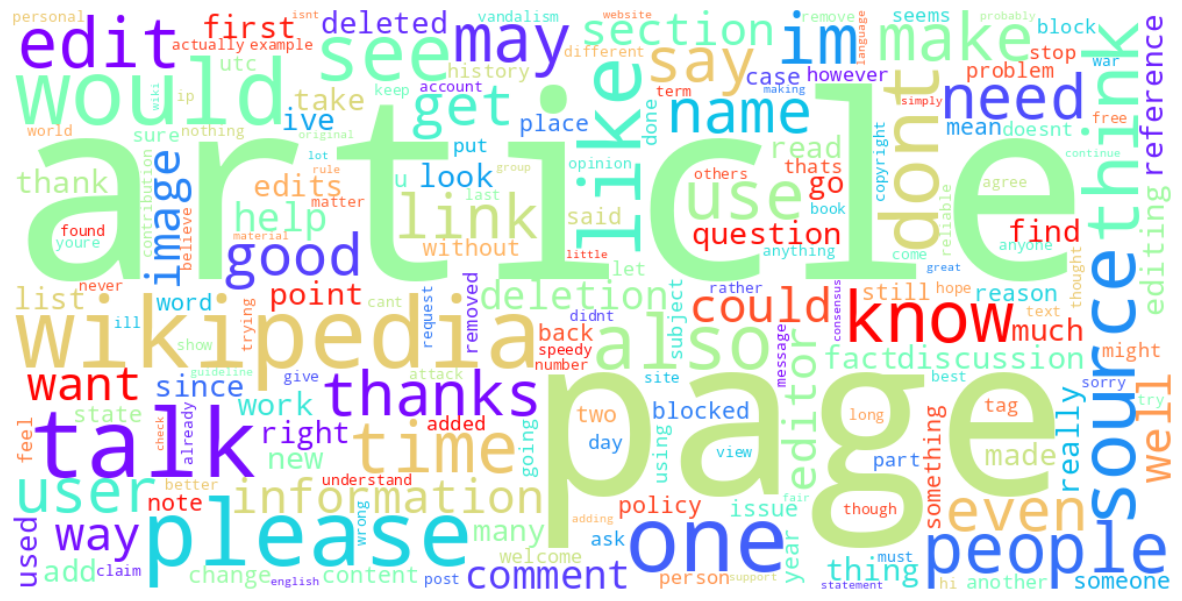

In [18]:
# Предобработаем все тексты и сохраним их в новый столбец

tqdm.pandas()
df_comments['lemm_text'] = df_comments['text'].progress_apply(preprocess_lemmatize)

# Проверим результат
display(df_comments.head(5))

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really try edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestion improvement wonder s...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


**Комментарии**

В датафрейме представлены данные интернет-магазина «Викишоп» с разметкой о токсичности. Была проведена предобработка данных, включающая удаление пунктуации, символов не английского алфавита, стопслов, а также токенизацию и лемматизацию. По результатам частотного анализа токсичных и нетоксичных комментариев можно сделать следующие выводы: 
- В топ-10 частотных слов токсичных комментариев преимущественно входит ненормативная лексика ("fuck", "suck", "shit", "nigger"), а также разговорная форма местоимения "you" ("u").
- В топ-10 частотных слов нетоксичных комментариев вошли слова с нейтральной окраской и вежливые формы обращения ("please", "would"+"like").
- Общими частотными словами стали "wikipedia", "like" и "dont".
- Облака слов токсичных и нетоксичных комментариев демонстрируют яркие различия в употребляемой авторами лексике.

## Обучение и анализ модели

Стоит задача построить модель со значением метрики качества *F1* не меньше 0.75. 


### Подготовка данных 

In [20]:
print("Количество пропусков в датафрейме:")
display(df_comments.isna().sum())

Количество пропусков в датафрейме:


text         0
toxic        0
lemm_text    0
dtype: int64

In [21]:
# Удаляем целевой признак

X_comments = df_comments.drop(['toxic', 'text'], axis=1)

# Сохраняем целевой признак

y_comments = df_comments['toxic']

In [22]:
# Разбиваем данные на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
        X_comments,
        y_comments,
        random_state=RANDOM_STATE,
        test_size=0.1
    )

In [23]:
# Считаем величину TF-IDF для обучающей и тестовой выборок

vectorizer = TfidfVectorizer(stop_words=STOP_WORDS)

train_tf_idf = vectorizer.fit_transform(X_train['lemm_text']) 
test_tf_idf = vectorizer.transform(X_test['lemm_text'])


###  Создание пайплайна

In [26]:
# Cоздаём пайплайн

pipe_final = Pipeline([
    #('preprocessor', data_preprocessor),
    #('tf_idf', TfidfVectorizer(stop_words=STOP_WORDS), text_columns),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])


In [27]:
# Создаем сетку гиперпараметров для моделей

param_grid = [
    # Словарь для модели LGBMClassifier()

    {
        'models': [LGBMClassifier()],
        'models__learning_rate': [0.01, 0.1],
        'models__max_depth': [8, 16, 32],
        'models__n_estimators': [100, 200, 300],
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # Словарь для модели DecisionTreeClassifier()

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(5, 10),
        'models__min_samples_leaf': range(2, 6),
        'models__min_samples_split': range(2, 6),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # Словарь для модели LogisticRegression()

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced', 
            solver='liblinear', 
            penalty='l2')],
        'models__C': range(1, 10),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

### Обучение модели и проверка на тестовых данных

In [28]:
# Обучим модель

start_time = time.time()  # начинаем замер общего времени

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=35,
    cv=3,
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(train_tf_idf, y_train)

end_time = time.time()  # заканчиваем замер общего времени
all_time = end_time - start_time
print(f"Время полного процесса поиска: {all_time:.2f} секунд")

best_model = randomized_search.best_estimator_
best_params = randomized_search.best_params_
best_f1 = randomized_search.best_score_

print('Лучшая модель:\n')
print(best_model)
print('Параметры лучшей модели:', best_params)
print ('F1 лучшей модели на кросс-валидации:', best_f1)

Время полного процесса поиска: 3650.23 секунд
Лучшая модель:

Pipeline(steps=[('models',
                 LogisticRegression(C=3, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])
Параметры лучшей модели: {'models__C': 3, 'models': LogisticRegression(C=3, class_weight='balanced', random_state=42,
                   solver='liblinear')}
F1 лучшей модели на кросс-валидации: 0.7565523942499738


**Комментарии**

Достигнув метрики F1 в 0.75 на кросс-валидации по обучающей выборке, лучше всех себя показала модель LogisticRegression(C=3, class_weight='balanced', solver='liblinear'). Теперь, проверим её качество на тестовой выборке.

In [29]:
# Проверим работу модели на тестовой выборке

predict = best_model.predict(test_tf_idf)
test_score = f1_score(y_test, predict)
print('Метрика F1 на тестовой выборке:', test_score)

Метрика F1 на тестовой выборке: 0.7652464494569757


**Комментарии**

Метрика F1 на тестовой выборке составила 0.76, что является критерием успеха. 

In [30]:
# Проверим модель с помощью DummyClassifier

dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier.fit(train_tf_idf, y_train)

pred_dummy = dummy_classifier.predict(test_tf_idf)

print("Метрика F1 DummyClassifier на тестовой выборке:", f1_score(y_test, pred_dummy))

Метрика F1 DummyClassifier на тестовой выборке: 0.09563014566181127


**Комментарии**

Метрика F1 равная 0.09 означает, что модель DummyClassifier абсолютно неэффективна для заданной задачи.

## Выводы

Для настоящего проекта нам были предоставлены данные интернет-магазина «Викишоп», который запускает новый сервис редактирования пользователями описания товаров, как в вики-сообществах. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель исследования**: Построить модель машинного обучения для классификации комментариев на позитивные и негативные. 

В **первом разделе** проекта мы изучили общую информацию о данных, провели основную предобработку и исследовательский анализ. Нам для анализа был предоставлен набор данных с разметкой о токсичности правок со следующими признаками:
- `text` — текст комментария.
- `toxic` — целевой признак.  

Датасет содержит 159292 строк и 2 столбца. Пропусков в данных нет. Целевой признак распределен 1:9. Была проведена предобработка данных, включающая удаление пунктуации, символов не английского алфавита, стопслов, а также токенизацию и лемматизацию. По результатам частотного анализа токсичных и нетоксичных комментариев можно сделать следующие выводы: 
- В топ-10 частотных слов токсичных комментариев преимущественно входит ненормативная лексика ("fuck", "suck", "shit", "nigger"), а также разговорная форма местоимения "you" ("u").
- В топ-10 частотных слов нетоксичных комментариев вошли слова с нейтральной окраской и вежливые формы обращения ("please", "would"+"like").
- Общими частотными словами стали "wikipedia", "like" и "dont".
- Облака слов токсичных и нетоксичных комментариев демонстрируют яркие различия в употребляемой авторами лексике.

Во **втором разделе** мы разделили данные на обучающую и тестовую выборки, а также посчитали величину TF-IDF для каждой из них. Далее мы подготовили пайплайн и использовали инструмент `RandomizedSearchCV` для поиска лучшей модели. Были проанализированы различные параметры моделей `LGBMClassifier()`, `DecisionTreeClassifier()` и `LogisticRegression()`. 

Достигнув метрики **F1 в 0.75** на кросс-валидации, и  **0.76** на тестовых данных, лучше всех себя показала модель `LogisticRegression(C=3, class_weight='balanced', solver='liblinear')`.

Таким образом, по итогам проведенного анализа и разработки моделей машинного обучения появится возможность искать токсичные комментарии и отправлять их на модерацию. Это важно для бизнеса, так как токсичные правки в описание товаров могут испортить имидж интернет-магазина, что повлияет на интерес пользователей и снизит продажи.